# **Number of Claims Estimation with Generalized Linear Models (GLMs)**

Generalized Linear Models introduced by Nelder and Wedeburn in the 1972, but applied in insurance 20 years later, overcome the limits of the linear models and now they are a benchmark for the non-life insurance tariff structure.
GLM is a generalization of the linear regression, modeling
various forms of dependency between the input features and the target variable.

References:

-["Case Study: French Motor Third-Party Liability Claims"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764), Mario V. Wuthrich, Alexander Noll, Robert Salzmann;

-["Data Analytics for Non-Life Insurance Pricing"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2870308), Mario V. Wuthrich, Christoph Buser;

-["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407), Mario V. Wuthrich, Michael Merz


# Upload Libraries

In [ ]:
# handling datasets
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# modelling, evaluation
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Upload File

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving swmotorcycle_ClaimNb.csv to swmotorcycle_ClaimNb.csv


In [ ]:
# Reading File
df = pd.read_csv('swmotorcycle_ClaimNb.csv')

# Data Set Overview

In [ ]:
# Dimensions of data set
print(df.shape)

(64548, 8)


In [ ]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OwnerAge    64548 non-null  int64  
 1   Gender      64548 non-null  object 
 2   Area        64548 non-null  object 
 3   RiskClass   64548 non-null  object 
 4   VehAge      64548 non-null  int64  
 5   BonusClass  64548 non-null  object 
 6   Exposure    64548 non-null  float64
 7   ClaimNb     64548 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.9+ MB
None


In [ ]:
# Take a peek at the first rows of the data
df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0


# Summary Statistics

In [ ]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,64548,2,Male,54695
Area,64548,7,Small towns; countryside except Gotland; North...,24816
RiskClass,64548,7,EV ratio 9-12,18905
BonusClass,64548,7,BM7,17953


In [ ]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df.columns if df[var].dtype!='object']
df[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,64548.0,42.416062,12.980960,0.0,31.000000,44.000000,52.0,92.00000
VehAge,64548.0,12.540063,9.727445,0.0,5.000000,12.000000,16.0,99.00000
Exposure,64548.0,1.010671,1.307424,0.0,0.463014,0.827397,1.0,31.33973
ClaimNb,64548.0,0.010798,0.107323,0.0,0.000000,0.000000,0.0,2.00000


# Data Cleaning

In [ ]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(64548, 8)


In [ ]:
# get number of unique values for each row
counts = df.duplicated()
# record rows to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
print(df.shape)

[]
(64548, 8)


In [ ]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

OwnerAge      0.0
Gender        0.0
Area          0.0
RiskClass     0.0
VehAge        0.0
BonusClass    0.0
Exposure      0.0
ClaimNb       0.0
dtype: float64

In [ ]:
# Feature transformation
df_1 = df.copy()
df_1['Exposure'] = df_1['Exposure'].clip(upper=1)
df_1['VehAge'] = df_1['VehAge'].clip(upper=20)

# Pre-Processing

In [ ]:
# Split dataset
df_train, df_test, = train_test_split(df_1, train_size=0.8, test_size=0.2,random_state=0)


In [ ]:
y_train = df_train.ClaimNb
y_test = df_test.ClaimNb
X_train = df_train.drop(['ClaimNb'], axis=1, inplace=False)
X_test = df_test.drop(['ClaimNb'], axis=1, inplace=False)

# Modelling 1

In [ ]:
np.random.seed(0)
glm_poisson_1 = smf.glm(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)+C(BonusClass)+OwnerAge+VehAge', data=df_train, offset=np.log1p(df_train['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
glm_model_1 = glm_poisson_1.fit()
print(glm_model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                            GLM   Df Residuals:                    51616
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2760.8
Date:                Tue, 30 Aug 2022   Deviance:                       4461.3
Time:                        16:34:35   Pearson chi2:                 5.37e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 1

In [ ]:
predictions_tr = glm_model_1.predict(X_train)
predictions_te = glm_model_1.predict(X_test)

In [ ]:
mean_poisson_deviance(y_train,predictions_tr)

0.08872421725625632

In [ ]:
mean_poisson_deviance(y_test,predictions_te)

0.09945123035591899

In [ ]:
np.sqrt(mean_squared_error(y_train, predictions_tr))

0.1052476632765837

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions_te))

0.11260518860368156

# Modelling 2

In [ ]:
np.random.seed(0)
glm_poisson_2 = smf.glm(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)+OwnerAge+VehAge', data=df_train, offset=np.log1p(df_train['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
glm_model_2 = glm_poisson_2.fit()
print(glm_model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                            GLM   Df Residuals:                    51622
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2776.5
Date:                Tue, 30 Aug 2022   Deviance:                       4492.8
Time:                        16:34:48   Pearson chi2:                 5.43e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 2

In [ ]:
predictions_tr_ = glm_model_2.predict(X_train)
predictions_te_ = glm_model_2.predict(X_test)

In [ ]:
mean_poisson_deviance(y_train,predictions_tr_)

0.08945921380930168

In [ ]:
mean_poisson_deviance(y_test,predictions_te_)

0.101253537050602

In [ ]:
np.sqrt(mean_squared_error(y_train, predictions_tr_))

0.10526497659325416

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions_te_))

0.11272884347606331

# Feature Engineering

In [ ]:
df_2 = df_1.copy()

In [ ]:
group_RiskClass = 'EV ratio 20-24'

In [ ]:
new_RiskClass = 'EV ratio >=20'

In [ ]:
df_2['RiskClass'] = df_2['RiskClass'].replace(group_RiskClass, new_RiskClass)

In [ ]:
# regroup labels
df_2['RiskClass'] = np.where(df_2['RiskClass'].isin(['EV ratio >25']), new_RiskClass, df_2['RiskClass'])
# check
[x for x in df_2.RiskClass.unique() if x not in df_2.RiskClass.unique()]

[]

In [ ]:
df_2['RiskClass'].unique()

array(['EV ratio 13-15', 'EV ratio >=20', 'EV ratio 9-12', 'EV ratio <5',
       'EV ratio 6-8', 'EV ratio 16-19'], dtype=object)

In [ ]:
group_RiskClass = 'EV ratio 6-8'

In [ ]:
new_RiskClass = 'EV ratio <9'

In [ ]:
df_2['RiskClass'] = df_2['RiskClass'].replace(group_RiskClass, new_RiskClass)

In [ ]:
# regroup labels
df_2['RiskClass'] = np.where(df_2['RiskClass'].isin(['EV ratio <5']), new_RiskClass, df_2['RiskClass'])
# check
[x for x in df_2.RiskClass.unique() if x not in df_2.RiskClass.unique()]

[]

In [ ]:
df_2['RiskClass'].unique()

array(['EV ratio 13-15', 'EV ratio >=20', 'EV ratio 9-12', 'EV ratio <9',
       'EV ratio 16-19'], dtype=object)

In [ ]:
group_RiskClass = 'EV ratio 13-15'

In [ ]:
new_RiskClass = 'EV ratio 9-15'

In [ ]:
df_2['RiskClass'] = df_2['RiskClass'].replace(group_RiskClass, new_RiskClass)

In [ ]:
# regroup labels
df_2['RiskClass'] = np.where(df_2['RiskClass'].isin(['EV ratio 9-12']), new_RiskClass, df_2['RiskClass'])
# check
[x for x in df_2.RiskClass.unique() if x not in df_2.RiskClass.unique()]

[]

In [ ]:
df_2['RiskClass'].unique()

array(['EV ratio 9-15', 'EV ratio >=20', 'EV ratio <9', 'EV ratio 16-19'],
      dtype=object)

In [ ]:
Gotland = "Gotland (Sweden's largest island)"

In [ ]:
new_Gotland = 'Gotland Islands'

In [ ]:
df_2['Area'] = df_2['Area'].replace(Gotland, new_Gotland)

In [ ]:
Lesser_towns = 'Lesser towns except Gotland; Northern towns'

In [ ]:
new_Lesser_towns = 'Lesser towns included Gotland Islands'

In [ ]:
df_2['Area'] = df_2['Area'].replace(Lesser_towns, new_Lesser_towns)

In [ ]:
# regroup labels
df_2['Area'] = np.where(df_2['Area'].isin(['Gotland Islands']), new_Lesser_towns, df_2['Area'])
# check
[x for x in df_2.Area.unique() if x not in df_2.Area.unique()]

[]

In [ ]:
df_2['Area'].unique()

array(["Central parts of Sweden's three largest cities",
       'Lesser towns included Gotland Islands',
       'Small towns; countryside except Gotland; Northern towns',
       'Suburbs; middle-sized cities', 'Northern countryside',
       'Northern towns'], dtype=object)

# Modelling 3

In [ ]:
df_train_, df_test_, = train_test_split(df_2, train_size=0.8, test_size=0.2,random_state=0)

In [ ]:
y_train_ = df_train_.ClaimNb
y_test_ = df_test_.ClaimNb
X_train_ = df_train_.drop(['ClaimNb'], axis=1, inplace=False)
X_test_= df_test_.drop(['ClaimNb'], axis=1, inplace=False)

In [ ]:
np.random.seed(0)
glm_poisson_3 = smf.glm(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)+OwnerAge+VehAge', data=df_train_, offset=np.log1p(df_train_['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
glm_model_3 = glm_poisson_3.fit()
print(glm_model_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                            GLM   Df Residuals:                    51626
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2783.1
Date:                Tue, 30 Aug 2022   Deviance:                       4505.9
Time:                        16:35:44   Pearson chi2:                 5.43e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 3

In [ ]:
predictions_train = glm_model_3.predict(X_train_)
predictions_test = glm_model_3.predict(X_test_)

In [ ]:
mean_poisson_deviance(y_train_,predictions_train)

0.0897810095397159

In [ ]:
mean_poisson_deviance(y_test_,predictions_test)

0.10173545721431132

In [ ]:
np.sqrt(mean_squared_error(y_train_, predictions_train))

0.1053004241195666

In [ ]:
np.sqrt(mean_squared_error(y_test_, predictions_test))

0.11277113644051838

# **GLM Results Analysis**

In [ ]:
coef = pd.DataFrame(np.exp(glm_model_3.params), columns = ['Value'])
coef

,Value
Intercept,0.094742
C(Gender)[T.Male],2.031885
C(RiskClass)[T.EV ratio 9-15],0.587161
C(RiskClass)[T.EV ratio <9],0.722177
C(RiskClass)[T.EV ratio >=20],1.341899
C(Area)[T.Lesser towns included Gotland Islands],0.395731
C(Area)[T.Northern countryside],0.251797
C(Area)[T.Northern towns],0.202174
C(Area)[T.Small towns; countryside except Gotland; Northern towns],0.358480
C(Area)[T.Suburbs; middle-sized cities],0.621895


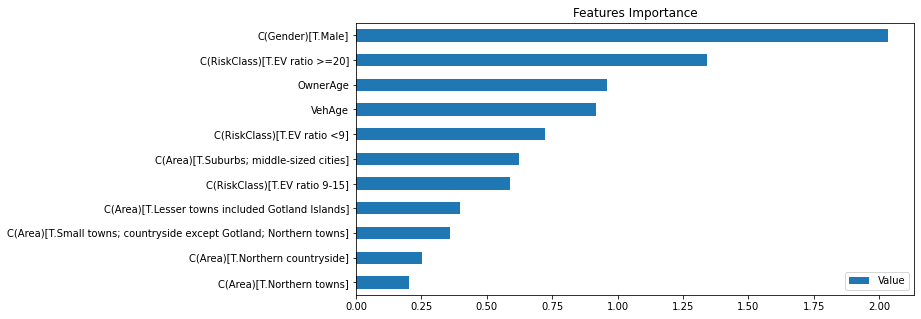

In [ ]:
# Features importance
coef_= coef.sort_values(by=['Value'])
coef.index.name="Coefficients"
coef_ = coef_.drop(['Intercept'])
plt.rcParams["figure.figsize"] = (10,5)
coef_.plot(kind='barh', use_index=True)
plt.title('Features Importance') 
plt.show()

In [ ]:
# attach predictions on test set
predictions_test = pd.DataFrame(predictions_test, columns=['ClaimNb_pred'])
test = pd.concat([X_test_, y_test_,predictions_test], axis=1)
test

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimNb_pred
11551,28,Female,Small towns; countryside except Gotland; North...,EV ratio >=20,13,BM3,0.419178,0,0.004708
27696,42,Female,Suburbs; middle-sized cities,EV ratio <9,4,BM7,0.983562,0,0.005380
56213,57,Male,Lesser towns included Gotland Islands,EV ratio 9-15,16,BM7,1.000000,0,0.001086
8463,26,Male,Central parts of Sweden's three largest cities,EV ratio 9-15,13,BM1,0.986301,0,0.012675
35448,45,Male,Small towns; countryside except Gotland; North...,EV ratio >=20,4,BM6,0.986301,0,0.010353
...,...,...,...,...,...,...,...,...,...
15776,31,Female,Lesser towns included Gotland Islands,EV ratio 9-15,15,BM7,0.989041,0,0.001692
43435,49,Male,Small towns; countryside except Gotland; North...,EV ratio 9-15,11,BM7,1.000000,0,0.002102
50162,53,Male,Suburbs; middle-sized cities,EV ratio 9-15,6,BM7,1.000000,0,0.004763
2912,22,Male,Suburbs; middle-sized cities,EV ratio 16-19,8,BM1,0.630137,0,0.024349


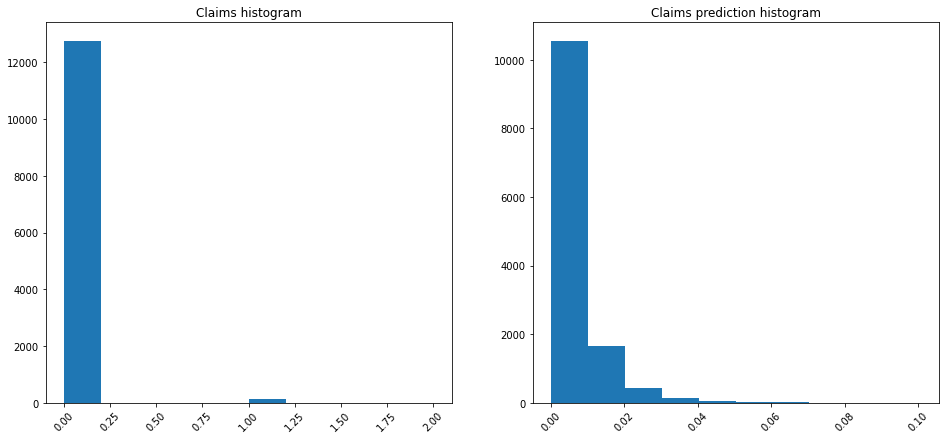

In [ ]:
# Claims and claims predicted comparison
fig = plt.figure(figsize = (16,7))
plt.subplot(1,2,1)  
plt.hist(test['ClaimNb'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims histogram')
plt.subplot(1,2,2)  
plt.hist(test['ClaimNb_pred'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims prediction histogram')
plt.show()

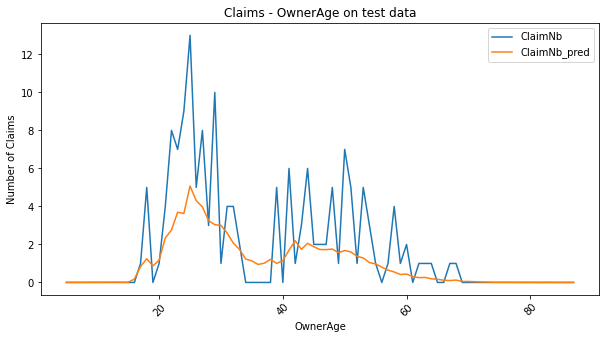

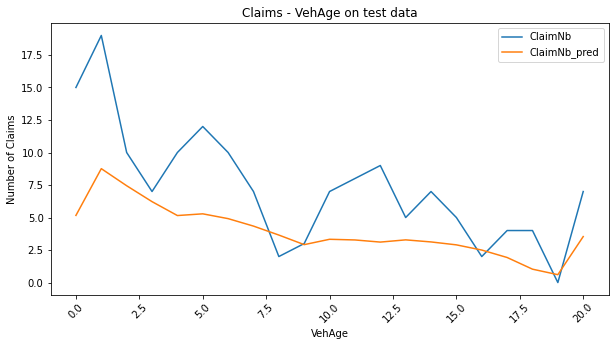

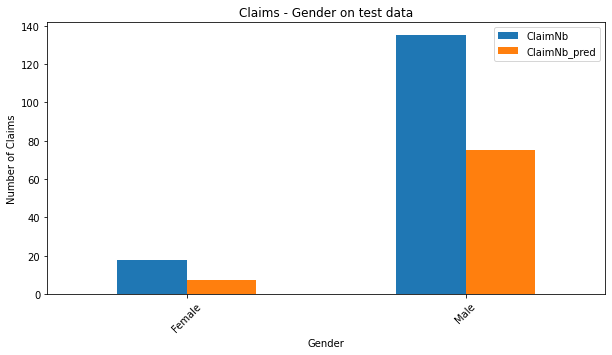

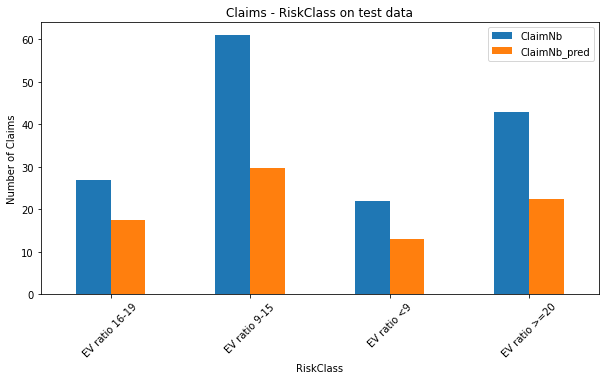

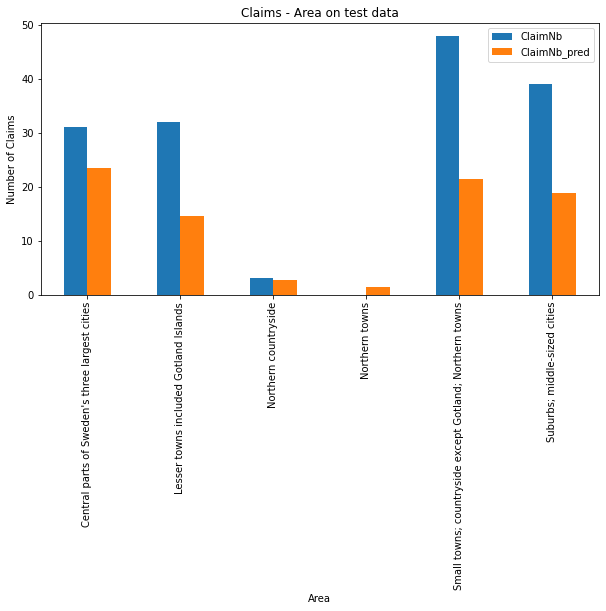

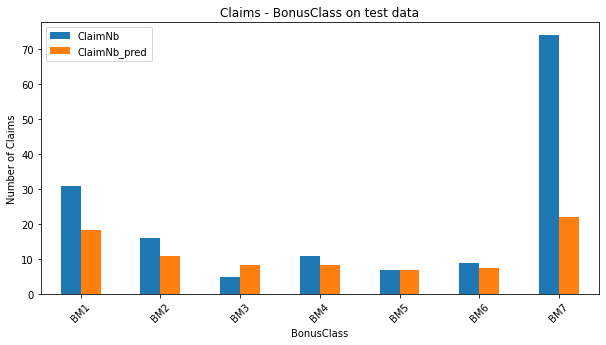

In [ ]:
# Claims and claims predicted comparison on features
plt.rcParams["figure.figsize"] = (10,5)
test_group_oa = test.groupby(['OwnerAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_oa.plot(x='OwnerAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('OwnerAge')
plt.title('Claims - OwnerAge on test data')
plt.show()
test_group_va = test.groupby(['VehAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_va.plot(x='VehAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('VehAge')
plt.title('Claims - VehAge on test data')
plt.show()
test_group_ge = test.groupby(['Gender'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_ge.plot.bar(x='Gender',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('Gender')
plt.title('Claims - Gender on test data')
plt.show()
test_group_rc = test.groupby(['RiskClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_rc.plot.bar(x='RiskClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('RiskClass')
plt.title('Claims - RiskClass on test data')
plt.show()
test_group_a = test.groupby(['Area'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_a.plot.bar(x='Area',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Area')
plt.title('Claims - Area on test data')
plt.show()
test_group_bc = test.groupby(['BonusClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_bc.plot.bar(x='BonusClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('BonusClass')
plt.title('Claims - BonusClass on test data')
plt.show()

